<a href="https://colab.research.google.com/github/Trouvler/Trouvler/blob/main/DANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DANN(Domain-Adversarial Training of Neural Networks)note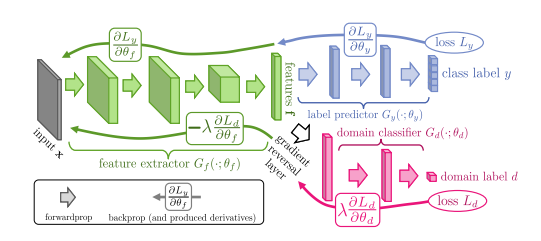

제안하는 알고리즘의 목표는 target domain의 label에 대한 정보가 없더라도 target risk가 낮도록 classifier η 를 만드는 것이다.

모델은 크게 feature extractor(초록), label predictor(파랑), domain classifier(빨강)로 구성.

일반적으로는 loss를 줄이는 쪽으로 학습하지만 해당모델은 Gradient Reversal layer를 domain classifier 앞에 배치하여 도메인 라벨을 구분을 어렵게하여 도메인간의 적응을 꾀함

작성자의 코드에서는 feature extractor를 베이스라인의 Unet()을 이용하였으며
label predictor 기존 Unet의 마지막 레이어인 conv_last를 가져왔고,domain classifier 또한 Linear Layer를 통해서 간단히 구현함

주의사항 해당코드는 딥린이의 생각으로 구현한 코드로 올바른 DANN모델이 아닐 수 있음

#구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#import

In [ ]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
import torch.optim as optim
from torch.nn import init
from torch.utils.data import Dataset, DataLoader,ConcatDataset
from torchvision import transforms
from torch.optim.lr_scheduler import LinearLR

from tqdm.notebook import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Utils

In [ ]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

#Csutom Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False, trg= False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        self.trg = trg

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
      if self.trg:
        img_path = self.data.iloc[idx, 1]
        path_len = len(img_path)
        image = cv2.imread('/content/drive/MyDrive/dacon/san'+img_path[1:path_len])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image is None:
            raise ValueError(f"Image not loaded from path: {img_path}")

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image
        else :
            if self.transform:
                image = self.transform(image=image)['image']
            return image
      else :
        img_path = self.data.iloc[idx, 1]
        path_len = len(img_path)
        image = cv2.imread('/content/drive/MyDrive/dacon/san'+img_path[1:path_len])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image is None:
            raise ValueError(f"Image not loaded from path: {img_path}")


        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_path = self.data.iloc[idx, 2]
        mask_path_len = len(mask_path)
        mask = cv2.imread('/content/drive/MyDrive/dacon/san'+ mask_path[1:mask_path_len], cv2.IMREAD_GRAYSCALE)
        mask[mask == 255] = 12 #배경을 픽셀값 12로 간주

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

#Data Loader

In [ ]:
transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

train_dataset = CustomDataset(csv_file='/content/drive/MyDrive/dacon/san/train_source.csv', transform=transform)
train_target_dataset = CustomDataset(csv_file='/content/drive/MyDrive/dacon/san/train_target.csv', transform=transform,trg=True)
val_dataset = CustomDataset(csv_file='/content/drive/MyDrive/dacon/san/val_source.csv', transform=transform)
combined_dataset = ConcatDataset([train_dataset, val_dataset])
train_source_dataloader = DataLoader(combined_dataset, batch_size=16, shuffle=True)
train_target_dataloader = DataLoader(train_target_dataset, batch_size=16, shuffle=True)

#Define Model

##Unet

In [ ]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        return x

## GradReverse

In [ ]:
class GradReverse(torch.autograd.Function):
    def forward(self, x):
        return x.view_as(x)

    def backward(self, grad_output): # 역전파 시에 gradient에 음수를 취함
        return (grad_output * -1)

##domain_classifier&label_classifier

In [ ]:
class domain_classifier(nn.Module):
    def __init__(self):
        super(domain_classifier, self).__init__()
        self.fc1 = nn.Linear(320, 10)
        self.fc2 = nn.Linear(10, 1) # mnist = 0, svhn = 1 회귀 가정

    def forward(self, x):
        x = GradReverse.apply(x) # gradient reverse
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)

class label_classifier(nn.Module):
    def __init__(self):
        super(label_classifier, self).__init__()
        self.conv_last = nn.Conv2d(320, 13, 1) # 12개 class + 1 background

    def forward(self, x):
        x = self.conv_last(x)
        return x

##DANN_UNET

In [ ]:
class DANN_Unet(nn.Module):
    def __init__(self, CNN):
        super(DANN_Unet, self).__init__()

        self.UNet = UNet() # CNN 구조 모델 받아오기

        self.domain_classifier = domain_classifier() # 도메인 분류 layer

        self.label_classifier = label_classifier() # 숫자 0 ~ 9 클래스 분류 layer

    def forward(self, img):
        UNet_output = self.UNet(img) # (batch, 100)
        pooled_output = torch.mean(UNet_output, dim=[2, 3]) # (batch, 64)

        domain_logits =  self.domain_classifier(pooled_output) # (batch, 1)

        label_logits = self.label_classifier(UNet_output) # (batch, 13, H, W)

        return domain_logits, label_logits

#LOSS

In [ ]:
class DANN_Loss(nn.Module):
    def __init__(self):
        super(DANN_Loss, self).__init__()

        # 0~9 class 분류용
        self.CE = nn.CrossEntropyLoss()
        self.BCE = nn.BCELoss() # 도메인 분류용

    # result : DANN_CNN에서 반환된 값
    # label : 숫자 0 ~ 9에 대한 라벨
    # domain_num : 0(mnist) or 1(svhn)
    def forward(self, result, label, domain_num, alpha = 1):
        domain_logits, label_logits = result # DANN_CNN의 결과

        batch_size = domain_logits.shape[0]
        domain_target = torch.FloatTensor([domain_num] * batch_size).unsqueeze(1).to(device)
        domain_loss = self.BCE(domain_logits, domain_target) # domain 분류 loss
        label_loss = self.CE(label_logits, label) # class 분류 loss


        return label_loss + (alpha*domain_loss)

In [ ]:
class DANN_target_Loss(nn.Module):
    def __init__(self):
        super(DANN_target_Loss, self).__init__()
        self.BCE = nn.BCELoss() # 도메인 분류용

    # result : DANN_CNN에서 반환된 값
    # label : 숫자 0 ~ 9에 대한 라벨
    # domain_num : 0(mnist) or 1(svhn)
    def forward(self, result, domain_num, alpha = 1):
        domain_logits, _ = result # DANN_CNN의 결과
        batch_size = domain_logits.shape[0]
        domain_target = torch.FloatTensor([domain_num] * batch_size).unsqueeze(1).to(device)
        domain_loss = self.BCE(domain_logits, domain_target) # domain 분류 loss
        domain_loss

        return domain_loss

#Model Train

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

66

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
best_loss = 1
patience = 5  # 성능 향상이 없을 때 얼마나 기다릴 것인지 결정하는 변수

model = DANN_Unet().to(device)

loss_fn = DANN_Loss().to(device)
loss_fn_tgt = DANN_target_Loss().to(device)
train_source_dataloader = DataLoader(combined_dataset, batch_size=8, shuffle=True)
train_target_dataloader = DataLoader(train_target_dataset, batch_size=8, shuffle=True)
epochs = 100
model.train()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=epochs * len(train_source_dataloader))

alpha = 0.5
checkpoint = 1
for i in range(1, epochs + 1):
    total_loss = 0
    src_loss = 0
    tgt_loss = 0
    print(f'epoch : {i}')

    progress_bar = tqdm(range(len(train_source_dataloader)))
    for step in progress_bar:
        # mnist, svhn에서 1 batch씩 가져오기
        # 각 batch 내 데이터 : 0번은 이미지 픽셀 값, 1번은 0 ~ 9 class 라벨 값
        source_images, source_mask = next(iter(train_source_dataloader))

        source_images = source_images.to(device)
        source_mask = source_mask.long().to(device)
        _, source_result = model(source_images)

        loss = loss_fn(source_result, source_mask, 0, alpha=0.5)
        src_loss += loss.item()
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        progress_bar.set_description(f'Epoch {i} source: {src_loss/(step+1):.4f}')

    progress_bar = tqdm(range(len(train_target_dataloader)))
    for step in progress_bar:
        target_images = next(iter(train_target_dataloader))

        target_images = target_images.to(device)
        target_result = model(target_images.to(device))

        target_loss = loss_fn_tgt(target_result, 1, alpha = 0.5)

        loss = target_loss
        tgt_loss += loss.item()
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        progress_bar.set_description(f'Epoch {i} Target Loss: {tgt_loss/(step+1):.4f}')

    if total_loss / len(train_source_dataloader) < best_loss:
        best_loss = total_loss / len(train_source_dataloader)
        print('save model')
        torch.save(model.state_dict(), model_save_path)
        torch.save(optimizer.state_dict(),optim_save_path)
        torch.save(scheduler.state_dict(), scheduler_save_path)


    print('Epoch : %d, Avg Loss : %.4f'%(i, total_loss / (len(train_source_dataloader) +len(train_target_dataloader))))




epoch : 1


  0%|          | 0/333 [00:00<?, ?it/s]

ValueError: ignored

#Inference

In [ ]:
test_dataset = CustomDataset(csv_file='/content/drive/MyDrive/dacon/san/test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
with torch.no_grad():
    my_UNet = UNet3Plus()

    model = nn.DataParallel(DANN_Unet(UNet())).to(device)
    model.load_state_dict(torch.load('/content/drive/MyDrive/dacon/san/save/best_Unet3P_Dann_model.pth'))

    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        _, outputs = model(images)
        outputs = torch.softmax(outputs, dim=1).cpu()
        outputs = torch.argmax(outputs, dim=1).numpy()
        # batch에 존재하는 각 이미지에 대해서 반복
        for pred in outputs:
            pred = pred.astype(np.uint8)
            pred = Image.fromarray(pred) # 이미지로 변환
            pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
            pred = np.array(pred) # 다시 수치로 변환
            # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
            for class_id in range(12):
                class_mask = (pred == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else: # 마스크가 존재하지 않는 경우 -1
                    result.append(-1)

  0%|          | 0/119 [00:00<?, ?it/s]

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dacon/san/sample_submission.csv')
submit['mask_rle'] = result
submit

,id,mask_rle
0,TEST_0000_class_0,213592 13 214552 13 215431 26 215487 51 216391...
1,TEST_0000_class_1,-1
2,TEST_0000_class_2,1 99 597 463 1557 471 2517 471 3477 471 4437 4...
3,TEST_0000_class_3,215324 8 216284 8 217244 8 221988 4 222044 4 2...
4,TEST_0000_class_4,90837 4 91797 4 92757 4 93717 4 94677 4 95637 ...
...,...,...
22771,TEST_1897_class_7,66237 4 67197 4 68157 4 69117 4 70072 9 71032 ...
22772,TEST_1897_class_8,91 86 284 351 678 129 1051 86 1244 351 1638 12...
22773,TEST_1897_class_9,211171 4 212131 4 213091 4 214051 9 215011 9 2...
22774,TEST_1897_class_10,215967 4 216927 4 217887 4


In [ ]:
submit.to_csv('/content/drive/MyDrive/dacon/san/Dann_unet3p_submit.csv', index=False)